## Go to resources -> change run time type -> select GPU


In [ ]:
!pip install transformers[torch]
!pip install accelerate

import torch
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from torchvision import models
import accelerate
from torchvision.models import resnet50, ResNet50_Weights

random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#ensure this says cuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 3.5 MB/s eta 0:00:00
cuda


In [ ]:
#Get Data
!pip install -q kaggle
!wget -O "kaggle.json" https://drive.google.com/u/0/uc?id=1Re9JNbEEGj_uyaG67mg_U09KPUaLUgzm&export=download
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d adityajn105/flickr30k
!unzip flickr30k.zip -d ./flickr30k/


Streaming output truncated to the last 5000 lines.
  inflating: ./flickr30k/Images/flickr30k_images/535529555.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/5356236664.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/5356318668.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/535830521.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/5359437945.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/5361355399.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/53614287.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/536147209.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/5361551308.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/536156200.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/5362687336.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/5363528971.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/5363903246.jpg  
  inflating: ./flickr30k/Images/flickr30k_images/5364849864.jpg  
  inflating: ./flickr30k/Images

In [ ]:
image_data_location = "./flickr30k/Images/flickr30k_images/"
caption_data_location = "./flickr30k/captions.txt"
df = pd.read_csv(caption_data_location)
#get unique image names, each image has 5 separate captions attached to it
image_names = df[['image']].drop_duplicates()


In [ ]:
df.head(5)

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their...
1,1000092795.jpg,"Two young , White males are outside near many..."
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


In [ ]:
image_names.head(5)

,image
0,1000092795.jpg
5,10002456.jpg
10,1000268201.jpg
15,1000344755.jpg
20,1000366164.jpg


## Part I: Extracting image features using a cnn

In [ ]:
#Defining Dataloader for Images
class CustomImageDataset(Dataset):
    def __init__(self, image_names, image_folder, transform=None):
        self.image_names = image_names
        self.image_folder = image_data_location
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_names.iloc[idx, 0])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

# Transforms if using inception
transform_inception = T.Compose([
    # Inception input Requirements
    T.Resize((299, 299)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Transforms if using resnet50
transform_resnet = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create a custom dataset
custom_dataset = CustomImageDataset(image_names=image_names, image_folder=image_data_location, transform=transform_resnet)

# Create a data loader
data_loader = DataLoader(custom_dataset, batch_size=32, shuffle=False)

In [ ]:
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
#change the last linear layer to extract 512 features
resnet50.fc=torch.nn.Linear(2048, 300)
#model to gpu
resnet50 = resnet50.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 85.5MB/s]


In [ ]:
resnet50.eval()
image_features = {}
i=0
image_ids = []
image_features = []
for image in data_loader:
    images=image.to(device)
    features = resnet50(images)
    image_features.append(features.data)
    images.detach()
    features.detach()
# #Concatenate the features from all batches
image_features = torch.cat(image_features, 0)

# names = torch.cat(names,0)

In [ ]:
image_features_original = image_features
image_features_original = image_features_original.tolist()

In [ ]:
image_features_names_dict = {}

for idx, id in enumerate(image_ids):
  image_features_names_dict[str(image_features_original[idx])] = id

In [ ]:
#repeat features because every image has 5 corresponding captions in the dataframe
num_repeats=5
image_features_repeated = image_features.unsqueeze(1).repeat(1, num_repeats, 1).view(-1, image_features.shape[1]).to("cpu")
image_features.detach()
image_features = None

In [ ]:
image_features_repeated = image_features_repeated.tolist()

## Part II: Processing captions to remove punctuation, tokenizing them, and building a vocabulary set assigning an index to each token

In [ ]:
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

df.fillna('', inplace=True)
vocab = set()
max_len = 45
captions_list = df['caption'].tolist()
image_names = df['image'].tolist()

table = str.maketrans('', '', string.punctuation)

tokenized_captions = []
for caption in captions_list:
  caption = caption.translate(table)
  tokens = word_tokenize(caption.lower())
  if len(tokens)>max_len-2:
    tokens = tokens[:max_len-2]
  vocab.update(tokens)
  tokens.insert(0, "<start>")
  tokens.append("<end>")
  while len(tokens)<max_len:
    tokens.append("<pad>")
  tokenized_captions.append(tokens)




vocab = sorted(vocab)
vocab_dict = {"<pad>": 0, "<start>":1, "<end>":2}
vocab_dict.update({word: idx + 3 for idx, word in enumerate(vocab)})
index_to_word = {idx: word for word, idx in vocab_dict.items()}


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# DataFrame Mapping the captions to their corresponding images
df_mappings = pd.DataFrame()
df_mappings['name'] = df['image']
df_tokens = [str(tokens) for tokens in tokenized_captions]
df_mappings['tokenized_captions'] = df_tokens
df_mappings['features'] = image_features_repeated


## Part III: Training a LSTM to take sequences of image features and caption embeddings as input

---
Note: the embedding size below needs to be the same as the feature output size for the extracted image features


In [ ]:
image_names = df['image'].tolist()

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data._utils.collate import default_convert


class MyDataset(Dataset):
    def __init__(self, image_features, tokenized_captions, image_names):
        self.image_features = image_features
        self.tokenized_captions = tokenized_captions
        self.image_names = image_names

    def __len__(self):
        return len(self.image_features)

    def __getitem__(self, idx):
        image_features = self.image_features[idx]
        tokenized_captions = self.tokenized_captions[idx]
        image_names = self.image_names[idx]
        return {"features": image_features, "captions":tokenized_captions, "names": self.image_names}

my_dataset = MyDataset(image_features_repeated, tokenized_captions, image_names)


# Split into test, validation, and train sets
total_samples = len(my_dataset)

train_size = int(0.75 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(my_dataset, [train_size, val_size, test_size])

# Create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True )
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=True)




In [ ]:
!wget glove.zip https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
!unzip glove.6B.zip -d ./glove/

--2023-12-17 20:20:58--  http://glove.zip/
Resolving glove.zip (glove.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘glove.zip’
--2023-12-17 20:20:58--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2023-12-17 20:20:58--  https://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.93MB/s    in 2m 41s  

In [ ]:
def load_glove_embeddings(file_path):
    word_to_index = {}
    embeddings = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for index, line in enumerate(f):
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            word_to_index[word] = index
            embeddings.append(vector)

    return word_to_index, np.array(embeddings)

# Adjust the file path based on the specific GloVe file you downloaded
glove_file_path = './glove/glove.6B.300d.txt'
word_to_index_pretrained, pretrained_embeddings = load_glove_embeddings(glove_file_path)

In [ ]:
#model defiinition

class CaptionLSTM(torch.nn.Module):

  def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
    super().__init__()
    self.embedding = torch.nn.Embedding(vocab_size, embed_size)

    for word_index in range(3,vocab_size):
      word = index_to_word[word_index]
      if word in word_to_index_pretrained:
          pretrained_index = word_to_index_pretrained[word]
          self.embedding.weight.data[word_index] = torch.tensor(pretrained_embeddings[pretrained_index])

    self.dropout = torch.nn.Dropout(0.3)
    self.num_layers=num_layers
    dropout_lstm=0
    if num_layers>1:
      dropout_lstm=0.3
    self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout_lstm, batch_first=True)
    self.linear = torch.nn.Linear(hidden_size, vocab_size)

  def forward(self, features, captions):

    embeddings = self.embedding(captions).to(device)
    embeddings = self.dropout(embeddings)
    features = features.float()
    inputs = torch.cat((features.unsqueeze(1), embeddings), dim=1)
    lstm_outputs, _ = self.lstm(inputs)
    lstm_outputs = self.dropout(lstm_outputs)
    outputs = self.linear(lstm_outputs)

    return outputs

  def init_hidden(self, batch_size):
    # Initialize both hidden state and cell state to zeros
    h_0 = torch.zeros(self.num_layers, batch_size, self.lstm.hidden_size).to(device)
    c_0 = torch.zeros(self.num_layers, batch_size, self.lstm.hidden_size).to(device)
    return h_0, c_0



In [ ]:
load_drive_model= False
vocab_size = len(vocab_dict)
embed_size = 300
hidden_size = 512
num_layers = 1
criterion = torch.nn.CrossEntropyLoss()


# Load previously trained model (the best yet) from my drive lol (does not work for some reason rip)
if load_drive_model:
  !wget -O "best_model.pt" https://drive.google.com/u/1/uc?id=1DTX6hfaCxhAethTrKSDLG5DOcJ07m6L8&export=download
  vocab_size = len(vocab_dict)
  embed_size = 512
  hidden_size = 1024
  num_layers = 2
  model = CaptionLSTM(vocab_size, embed_size, hidden_size, num_layers)
  model.to(device)

#train model
else:
  model = CaptionLSTM(vocab_size, embed_size, hidden_size, num_layers)
  model.to(device)
  #loss function and optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.008)

  # Training loop
  num_epochs = 25
  best_model_path = 'best_model.pt'
  best_val_loss=float('inf')
  no_improv=0

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
      optimizer.zero_grad()

      image_features, caption_tokens, image_names = batch["features"], batch["captions"], batch["names"]
      image_features = torch.stack(image_features).transpose(0,1).to(device)  # Use torch.stack() to concatenate tensors
      caption_indices = [[vocab_dict[token] for token in caption_token] for caption_token in caption_tokens]
      caption_indices = torch.LongTensor(caption_indices).transpose(0,1).to(device)

      # Forward pass
      outputs = model(image_features, caption_indices)
      # Calculate loss
      loss = criterion(outputs[:, 1:, :].permute(0, 2, 1), caption_indices)
      train_loss += loss.item()

      # Backward pass
      loss.backward()
      optimizer.step()

    average_train_loss = train_loss/ len(train_loader)

    # Validation loop
    model.eval()
    avg_val_loss=0.0
    with torch.no_grad():
      val_loss = 0.0
      for batch in val_loader:
        images_val, caption_tokens_val, image_names_val = batch["features"], batch["captions"], batch["names"]
        images_val = torch.stack(images_val).transpose(0,1).to(device)
        caption_indices_val = [[vocab_dict[token_val] for token_val in caption_token_val] for caption_token_val in caption_tokens_val]
        caption_indices_val = torch.LongTensor(caption_indices_val).transpose(0,1).to(device)

        outputs_val = model(images_val, caption_indices_val)

        #one_hot_captions_val = torch.nn.functional.one_hot(caption_indices_val.long(), num_classes=len(vocab_dict)).float()

        val_loss += criterion(outputs_val[:,1:,:].permute(0, 2, 1), caption_indices_val).item()

      avg_val_loss = val_loss / len(val_loader)


    val_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}')

    #save parameters if new model is the best one yet
    if avg_val_loss < best_val_loss:
      no_improv=0
      print(f"Validation loss improved from {best_val_loss:.8f} to {avg_val_loss:.8f}")
      best_val_loss = avg_val_loss
      torch.save(model.state_dict(), best_model_path)
      print(f'Saved best model parameters to {best_model_path}')
    else:
      no_improv+=1
    if no_improv==3:
      print("No improvement in validation loss after 5 epochs, stopping training")
      break




Epoch [1/25], Loss: 0.0073, Val Loss: 0.0236
Validation loss improved from inf to 0.02362728
Saved best model parameters to best_model.pt
Epoch [2/25], Loss: 0.0257, Val Loss: 0.0191
Validation loss improved from 0.02362728 to 0.01905995
Saved best model parameters to best_model.pt
Epoch [3/25], Loss: 0.0075, Val Loss: 0.0185
Validation loss improved from 0.01905995 to 0.01854411
Saved best model parameters to best_model.pt
Epoch [4/25], Loss: 0.0066, Val Loss: 0.0194
Epoch [5/25], Loss: 0.0051, Val Loss: 0.0199
Epoch [6/25], Loss: 0.0055, Val Loss: 0.0211
No improvement in validation loss after 5 epochs, stopping training


In [ ]:
#compare predicted caption fror a random example in the validation set from the previous cell
if not load_drive_model:
  predicted_indices = torch.argmax(outputs_val, dim=-1)
  output_caption=[]
  for index in predicted_indices[60]:
    output_caption.append(index_to_word[index.item()])
  print(output_caption)

  input_caption=[]
  for index in caption_indices_val[60]:
    input_caption.append(index_to_word[index.item()])
  print(input_caption)

['modernistic', '<start>', 'a', 'little', 'kid', 'holding', 'a', 'yellow', 'and', 'red', 'soccer', 'toy', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<start>', 'a', 'little', 'kid', 'holding', 'a', 'yellow', 'and', 'red', 'soccer', 'toy', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## Test Loop w BLEU Score Integrated

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Testing loop
model.eval()
test_loss = 0.0
running_bleu_score = 0.0
predicted_captions = []
input_captions_all=[]

with torch.no_grad():
    for batch in test_loader:
        images_test, caption_tokens_test, image_names_test = batch["features"], batch["captions"], batch["names"]
        images_test = torch.stack(images_test).transpose(0, 1).to(device)
        caption_indices_test = [[vocab_dict[token_test] for token_test in caption_token_test] for caption_token_test in caption_tokens_test]
        caption_indices_test = torch.LongTensor(caption_indices_test).transpose(0, 1).to(device)

        outputs_test = model(images_test, caption_indices_test)
        # Calculate loss
        test_loss += criterion(outputs_test[:, 1:, :].permute(0, 2, 1), caption_indices_test).item()


        #compare predicted caption for a random example in the test set from the previous cell
        predicted_indices = torch.argmax(outputs_test, dim=-1)
        # Add a fix for the issue with the model that makes it have a longer than normal length, trim down last
        # padding character
        predicted_indices = predicted_indices[:,1:]
        # list to store all predicted captions from test set
        predicted_captions = []
        # Obtain and concatenate the captions
        for i in range(0, len(predicted_indices)):
          output_caption = []
          for index in predicted_indices[i]:
            output_caption.append(index_to_word[index.item()])
          predicted_captions.append(output_caption)
        # print(predicted_captions)
        # List to store all input captions for comparison, from the test set
        input_captions_all=[]
        for i in range(0, len(caption_indices_test)):
          input_caption = []
          for index in caption_indices_test[i]:
            input_caption.append(index_to_word[index.item()])
          input_captions_all.append(input_caption)
        # print(input_captions_all)

        # Calculate BLEU Score for batch
        batch_bleu_score = corpus_bleu([[reference] for reference in input_captions_all], predicted_captions)
        running_bleu_score += batch_bleu_score

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')
overall_bleu_score = running_bleu_score / len(test_loader)
print("Average BLEU Score:", overall_bleu_score)

Test Loss: 0.0202
Average BLEU Score: 0.996605461144301


## Evaluation - Show a few examples from test set

Add in figures showing a few images and their associated captions, trim out the pad, start, and end tokens

In [ ]:
# Helper function for decoding the caption
def decode(caption_tokenized):
  if (caption_tokenized.index('<start>') < caption_tokenized.index('<end>')):
    start_idx = caption_tokenized.index('<start>')
    end_idx = caption_tokenized.index('<end>')
    caption = caption_tokenized[start_idx+1:end_idx]
    final_caption = " ".join(caption)
    return final_caption

Given Caption:  a decorated car headed down the street
Predicted Caption:  a decorated car headed down the street


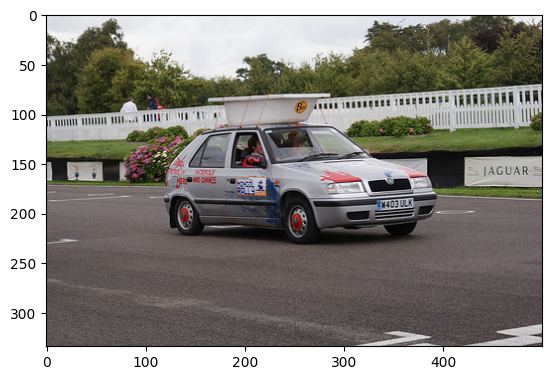

Given Caption:  two women one darkhaired the other blond with a tattoo on her right shoulder laugh together
Predicted Caption:  two women one darkhaired the other blond with a tattoo on her right shoulder laugh together


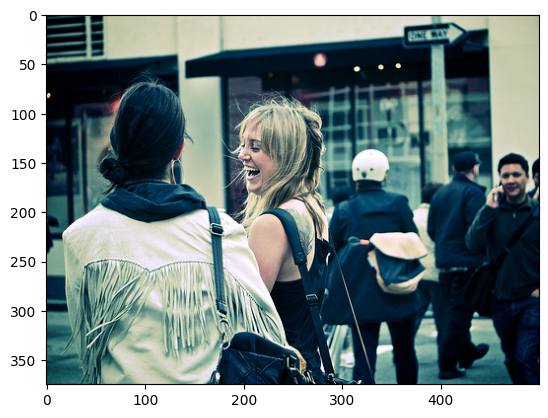

Given Caption:  local people commute through a bazaar that sells etiquette specific to the town s culture
Predicted Caption:  local people commuting through a bazaar that sells bunkbed specific to the town s culture


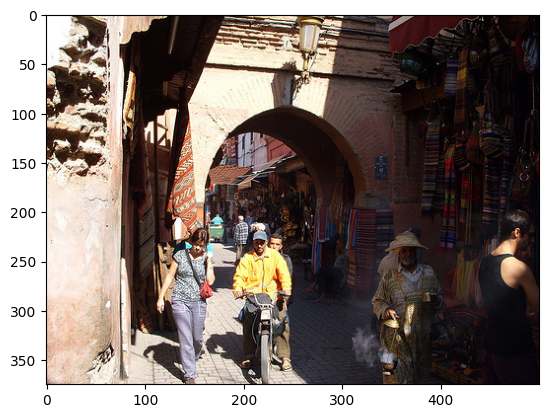

Given Caption:  a priest leads mass to his parish
Predicted Caption:  a priest leads mass to his colonial


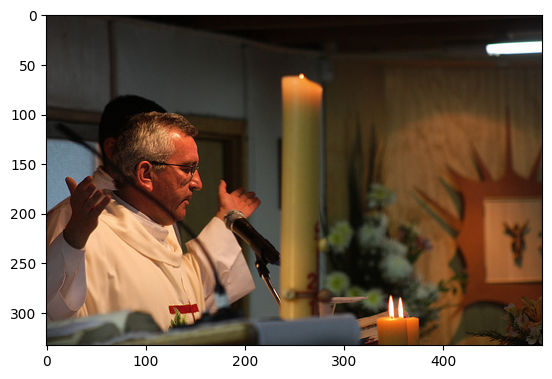

Given Caption:  a baby is being coddled to calm him down as he finishes a crying tantrum
Predicted Caption:  a baby is being judged to calm him down as he finishes a crying tantrum


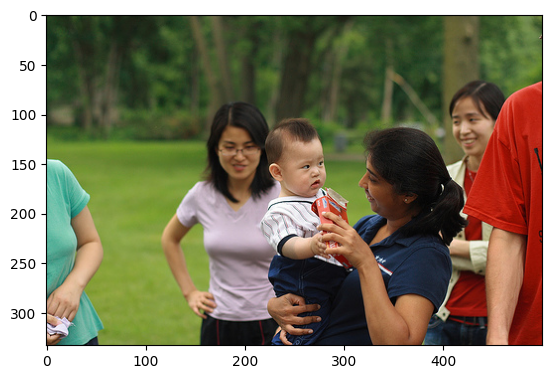

In [ ]:
# Choose 5 indices randomly
chosen_indices = [1, 28, 45, 7, 60]
for idx, sample in enumerate(chosen_indices):
  input_caption = input_captions_all[sample]
  img_name = df_mappings[df_mappings['tokenized_captions'] == str(input_caption)]['name'].tolist()
  decoded_input_caption = decode(input_captions_all[sample])
  print("Given Caption: ", decoded_input_caption)
  decoded_output_caption = decode(predicted_captions[sample])
  print("Predicted Caption: ", decoded_output_caption)
  img_loaded = plt.imread(os.path.join(image_data_location, str(img_name[0])))
  fig = plt.figure(idx)
  plt.imshow(img_loaded)
  plt.show()
